In [3]:
import os
import torchaudio
import torch
import matplotlib.pyplot as plt
from torch.nn import Module, Linear, Sigmoid, LSTM, BCELoss
from torch.optim import Adam
import torch.nn.functional as F
from pytorch_model_summary import summary
from tqdm import tqdm
import numpy as np
import pickle

In [4]:
from DataLoader import DataLoaderAll

X,Y,speech,mix1,X_complex = DataLoaderAll.data_loader(n_noise=100)

# MaskNet + Training

In [5]:
# MASK NET
HIDDEN_SIZE=128#1024 # 256
SAMPLE_RATE = 16000
INPUT_CHANNEL = 4 # Always two -> Real and Imaginary part 

class MaskNet(Module):
    def __init__(self,noise=False):
        super(MaskNet, self).__init__()
        # First subnet for speech prediction
        self.noise = noise
        self.lstm = LSTM(input_size=INPUT_CHANNEL, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        self.fc = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        self.sigmoid = Sigmoid()
        # # Second subnet for noise prediction
        # self.noise2 = noise
        # self.lstm2 = LSTM(input_size=INPUT_CHANNEL, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        # self.fc2 = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        # self.sigmoid2 = Sigmoid()

    def forward(self,x):
        # Speech prediction
        y, (h_n, c_n) = self.lstm(x)
        y = self.fc(y)
        speech_pred = self.sigmoid(y)
        return speech_pred.reshape(513,-1)#, noise_pred

print(summary(MaskNet(),torch.zeros((513, 196, 4))))

-----------------------------------------------------------------------------------------------------
      Layer (type)                                      Output Shape         Param #     Tr. Param #
            LSTM-1     [513, 196, 256], [4, 196, 128], [4, 196, 128]         532,480         532,480
          Linear-2                                     [513, 196, 1]             257             257
         Sigmoid-3                                     [513, 196, 1]               0               0
Total params: 532,737
Trainable params: 532,737
Non-trainable params: 0
-----------------------------------------------------------------------------------------------------


In [20]:
EPOCHS = 100
LEN_TRAIN = 2000
NUM_CHANNEL = 2 # Number of Mic Inputs (>=2 for BF)
REFERENCE_CHANNEL = 0
INIT_LR = 0.01
BATCH_SIZE = 1#64
LEARN_LOSS_PARAMS = False
device =  torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

model = MaskNet().to(device)
model= torch.nn.DataParallel(model,device_ids=[3])

lossBCE = BCELoss()

opt = Adam(model.parameters(), lr=INIT_LR)

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

def check_accuracy_training(speech_pred, y_s):
    speech_pred = (speech_pred>0.15).float()
    return float(torch.sum((speech_pred == y_s).float())/torch.sum(torch.ones(513,speech_pred.shape[1])))

def check_accuracy_validation(model):
    example_nr = int(np.random.random()*(len(X)-LEN_TRAIN)+LEN_TRAIN)
    model.eval()
    pred = model(X[example_nr])
    val_loss = lossBCE(pred,Y[example_nr][0])
    pred = (pred>0.15).float()
    model.train()
    return float(torch.sum((pred == Y[example_nr][0]).float())/torch.sum(torch.ones(513,X[example_nr].shape[1]))),val_loss

print("[INFO] training the network...")
#X = stft_mix[:50].to(device)
#Y = Y.to(device)
X = X.to(device)
Y = Y.to(device)
trainX = X[:LEN_TRAIN]
trainY = Y

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    for i in tqdm(range(0,len(trainX))): # Iterate over Training Examples
        y_s = trainY[i][0] # 0 speech only
        x = trainX[i]
        speech_pred=model(x)#, noise_pred = model(x)
        loss = lossBCE(speech_pred,y_s) #+ lossMSE(noise_pred,y_n)
        # zero out the gradients, perform the backpropagation step, and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        H["train_acc"].append(check_accuracy_training(speech_pred,y_s))
        H["train_loss"].append(float(loss))
        if i % 10 == 0:
            val_acc, val_loss = check_accuracy_validation(model)
            H["val_acc"].append(val_acc)
            H["val_loss"].append(float(val_loss))
    # Print results of Epoch        
    print("Average Training Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["train_acc"])))
    print("Total Training Loss in Epoch",str(epoch+1),":",np.sum(np.array(H["train_loss"])))
    print("Average Validation Accuracy in Epoch",str(epoch+1),":",np.mean(np.array(H["val_acc"])))
    print("Total Validation Loss in Epoch",str(epoch+1),":",np.sum(np.array(H["val_loss"])))
    # Save Model after Epoch        
    MODEL_SAVE_PATH = "/project/data_asr/CHiME5/data/librenoise/models/LSTMall"
    if (epoch+1)%10 == 0:
        torch.save(model.state_dict(), MODEL_SAVE_PATH + "epoch" + str(epoch+1) + ".pt")
    print(totalTrainLoss)
PICKLE_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/paramsLSTM.pkl'
torch.save(model.state_dict(), MODEL_SAVE_PATH + "final" + ".pt")
with open(PICKLE_SAVE_PATH, 'wb') as f:
    pickle.dump(H, f)

[INFO] training the network...
Epoch: 1/100


100%|██████████| 2000/2000 [04:09<00:00,  8.02it/s]


Average Training Accuracy in Epoch 1 : 0.5612612806595861
Total Training Loss in Epoch 1 : 1062.703752361238
Average Validation Accuracy in Epoch 1 : 0.5725868513807655
Total Validation Loss in Epoch 1 : 111.75044540688396
0
Epoch: 2/100


100%|██████████| 2000/2000 [03:54<00:00,  8.55it/s]


Average Training Accuracy in Epoch 2 : 0.560734392972663
Total Training Loss in Epoch 2 : 2125.9768913257867
Average Validation Accuracy in Epoch 2 : 0.5642056058906019
Total Validation Loss in Epoch 2 : 225.9551899395883
0
Epoch: 3/100


100%|██████████| 2000/2000 [04:39<00:00,  7.16it/s]


Average Training Accuracy in Epoch 3 : 0.5606526249311864
Total Training Loss in Epoch 3 : 3189.128782937303
Average Validation Accuracy in Epoch 3 : 0.5660632677500447
Total Validation Loss in Epoch 3 : 335.5087054669857
0
Epoch: 4/100


100%|██████████| 2000/2000 [04:58<00:00,  6.69it/s]


Average Training Accuracy in Epoch 4 : 0.5593447053153068
Total Training Loss in Epoch 4 : 4256.86527938582
Average Validation Accuracy in Epoch 4 : 0.5601859833300114
Total Validation Loss in Epoch 4 : 452.2201488763094
0
Epoch: 5/100


100%|██████████| 2000/2000 [04:58<00:00,  6.70it/s]


Average Training Accuracy in Epoch 5 : 0.5589574591621757
Total Training Loss in Epoch 5 : 5321.996533116326
Average Validation Accuracy in Epoch 5 : 0.5600770453214645
Total Validation Loss in Epoch 5 : 564.6560141444206
0
Epoch: 6/100


100%|██████████| 2000/2000 [04:55<00:00,  6.77it/s]


Average Training Accuracy in Epoch 6 : 0.5585898763729881
Total Training Loss in Epoch 6 : 6387.525823997334
Average Validation Accuracy in Epoch 6 : 0.5598295286173621
Total Validation Loss in Epoch 6 : 675.2043346576393
0
Epoch: 7/100


100%|██████████| 2000/2000 [04:53<00:00,  6.80it/s]


Average Training Accuracy in Epoch 7 : 0.5585182410036879
Total Training Loss in Epoch 7 : 7450.791777592152
Average Validation Accuracy in Epoch 7 : 0.5604744492577655
Total Validation Loss in Epoch 7 : 785.863754529506
0
Epoch: 8/100


100%|██████████| 2000/2000 [04:55<00:00,  6.76it/s]


Average Training Accuracy in Epoch 8 : 0.5585077003254555
Total Training Loss in Epoch 8 : 8512.889707326889
Average Validation Accuracy in Epoch 8 : 0.5631024203170091
Total Validation Loss in Epoch 8 : 894.8768087662756
0
Epoch: 9/100


100%|██████████| 2000/2000 [04:56<00:00,  6.74it/s]


Average Training Accuracy in Epoch 9 : 0.5586584128174517
Total Training Loss in Epoch 9 : 9574.406441308558
Average Validation Accuracy in Epoch 9 : 0.5606914276753863
Total Validation Loss in Epoch 9 : 1011.6551932543516
0
Epoch: 10/100


100%|██████████| 2000/2000 [04:07<00:00,  8.08it/s]


Average Training Accuracy in Epoch 10 : 0.5587320942908526
Total Training Loss in Epoch 10 : 10636.20606046915
Average Validation Accuracy in Epoch 10 : 0.5608752863369882
Total Validation Loss in Epoch 10 : 1130.3026290014386
0
Epoch: 11/100


100%|██████████| 2000/2000 [03:48<00:00,  8.76it/s]


Average Training Accuracy in Epoch 11 : 0.5589442866715518
Total Training Loss in Epoch 11 : 11698.401724733412
Average Validation Accuracy in Epoch 11 : 0.5598325681788
Total Validation Loss in Epoch 11 : 1242.75932270661
0
Epoch: 12/100


100%|██████████| 2000/2000 [04:24<00:00,  7.55it/s]


Average Training Accuracy in Epoch 12 : 0.5589073094424482
Total Training Loss in Epoch 12 : 12761.648352079093
Average Validation Accuracy in Epoch 12 : 0.5609465492299447
Total Validation Loss in Epoch 12 : 1356.3037711791694
0
Epoch: 13/100


100%|██████████| 2000/2000 [04:46<00:00,  6.99it/s]


Average Training Accuracy in Epoch 13 : 0.5590397028384301
Total Training Loss in Epoch 13 : 13822.283581819385
Average Validation Accuracy in Epoch 13 : 0.5613986901852946
Total Validation Loss in Epoch 13 : 1467.6134147681296
0
Epoch: 14/100


100%|██████████| 2000/2000 [04:45<00:00,  7.01it/s]


Average Training Accuracy in Epoch 14 : 0.5591146785627519
Total Training Loss in Epoch 14 : 14882.72879740037
Average Validation Accuracy in Epoch 14 : 0.5606620430387557
Total Validation Loss in Epoch 14 : 1585.6208924464881
0
Epoch: 15/100


100%|██████████| 2000/2000 [04:42<00:00,  7.07it/s]


Average Training Accuracy in Epoch 15 : 0.5590841095082462
Total Training Loss in Epoch 15 : 15944.684526985511
Average Validation Accuracy in Epoch 15 : 0.5590998841325442
Total Validation Loss in Epoch 15 : 1700.4730977527797
0
Epoch: 16/100


100%|██████████| 2000/2000 [04:42<00:00,  7.07it/s]


Average Training Accuracy in Epoch 16 : 0.5592181895826943
Total Training Loss in Epoch 16 : 17004.835746264085
Average Validation Accuracy in Epoch 16 : 0.5588966370606795
Total Validation Loss in Epoch 16 : 1814.423885602504
0
Epoch: 17/100


100%|██████████| 2000/2000 [04:41<00:00,  7.10it/s]


Average Training Accuracy in Epoch 17 : 0.5592661138878149
Total Training Loss in Epoch 17 : 18065.37831163779
Average Validation Accuracy in Epoch 17 : 0.5595753114013111
Total Validation Loss in Epoch 17 : 1924.2635320462286
0
Epoch: 18/100


100%|██████████| 2000/2000 [04:41<00:00,  7.10it/s]


Average Training Accuracy in Epoch 18 : 0.5593837998581843
Total Training Loss in Epoch 18 : 19124.65084855631
Average Validation Accuracy in Epoch 18 : 0.5601335767822133
Total Validation Loss in Epoch 18 : 2035.566301882267
0
Epoch: 19/100


100%|██████████| 2000/2000 [04:41<00:00,  7.11it/s]


Average Training Accuracy in Epoch 19 : 0.5595448907731395
Total Training Loss in Epoch 19 : 20183.209548272192
Average Validation Accuracy in Epoch 19 : 0.5595385962175695
Total Validation Loss in Epoch 19 : 2151.9815860912204
0
Epoch: 20/100


100%|██████████| 2000/2000 [04:39<00:00,  7.15it/s]


Average Training Accuracy in Epoch 20 : 0.5596275575602427
Total Training Loss in Epoch 20 : 21242.127594878897
Average Validation Accuracy in Epoch 20 : 0.5597492324188351
Total Validation Loss in Epoch 20 : 2265.7280491366982
0
Epoch: 21/100


100%|██████████| 2000/2000 [04:40<00:00,  7.13it/s]


Average Training Accuracy in Epoch 21 : 0.5597561450925257
Total Training Loss in Epoch 21 : 22299.4720182959
Average Validation Accuracy in Epoch 21 : 0.5604295172595553
Total Validation Loss in Epoch 21 : 2377.303584456444
0
Epoch: 22/100


100%|██████████| 2000/2000 [04:42<00:00,  7.07it/s]


Average Training Accuracy in Epoch 22 : 0.559832123231312
Total Training Loss in Epoch 22 : 23358.958829754964
Average Validation Accuracy in Epoch 22 : 0.560306453386491
Total Validation Loss in Epoch 22 : 2494.44800311327
0
Epoch: 23/100


100%|██████████| 2000/2000 [04:42<00:00,  7.07it/s]


Average Training Accuracy in Epoch 23 : 0.5599698301087255
Total Training Loss in Epoch 23 : 24416.84227838926
Average Validation Accuracy in Epoch 23 : 0.5599677311256528
Total Validation Loss in Epoch 23 : 2605.076360337436
0
Epoch: 24/100


100%|██████████| 2000/2000 [04:42<00:00,  7.08it/s]


Average Training Accuracy in Epoch 24 : 0.5600624072624681
Total Training Loss in Epoch 24 : 25474.24426493235
Average Validation Accuracy in Epoch 24 : 0.5609461722895503
Total Validation Loss in Epoch 24 : 2718.819732271135
0
Epoch: 25/100


100%|██████████| 2000/2000 [04:41<00:00,  7.11it/s]


Average Training Accuracy in Epoch 25 : 0.5601638731659949
Total Training Loss in Epoch 25 : 26531.70966395177
Average Validation Accuracy in Epoch 25 : 0.5610052414625883
Total Validation Loss in Epoch 25 : 2832.461951725185
0
Epoch: 26/100


100%|██████████| 2000/2000 [04:41<00:00,  7.10it/s]


Average Training Accuracy in Epoch 26 : 0.5602260084796984
Total Training Loss in Epoch 26 : 27590.021786255762
Average Validation Accuracy in Epoch 26 : 0.5608488400495396
Total Validation Loss in Epoch 26 : 2945.4189297519624
0
Epoch: 27/100


100%|██████████| 2000/2000 [04:40<00:00,  7.12it/s]


Average Training Accuracy in Epoch 27 : 0.5602415181686757
Total Training Loss in Epoch 27 : 28649.228480814025
Average Validation Accuracy in Epoch 27 : 0.5609244051037563
Total Validation Loss in Epoch 27 : 3061.625385977328
0
Epoch: 28/100


100%|██████████| 2000/2000 [04:40<00:00,  7.12it/s]


Average Training Accuracy in Epoch 28 : 0.5603099574529167
Total Training Loss in Epoch 28 : 29706.935509534553
Average Validation Accuracy in Epoch 28 : 0.5610129327526582
Total Validation Loss in Epoch 28 : 3172.369747951627
0
Epoch: 29/100


100%|██████████| 2000/2000 [04:40<00:00,  7.13it/s]


Average Training Accuracy in Epoch 29 : 0.5604180762247536
Total Training Loss in Epoch 29 : 30763.350515870377
Average Validation Accuracy in Epoch 29 : 0.561218512880391
Total Validation Loss in Epoch 29 : 3284.088803894818
0
Epoch: 30/100


100%|██████████| 2000/2000 [04:41<00:00,  7.11it/s]


Average Training Accuracy in Epoch 30 : 0.5605158413283526
Total Training Loss in Epoch 30 : 31819.876689836383
Average Validation Accuracy in Epoch 30 : 0.5617942192330957
Total Validation Loss in Epoch 30 : 3397.484386600554
0
Epoch: 31/100


100%|██████████| 2000/2000 [04:42<00:00,  7.08it/s]


Average Training Accuracy in Epoch 31 : 0.5606157443352765
Total Training Loss in Epoch 31 : 32875.52249699086
Average Validation Accuracy in Epoch 31 : 0.5614906642754232
Total Validation Loss in Epoch 31 : 3513.2978336960077
0
Epoch: 32/100


100%|██████████| 2000/2000 [04:42<00:00,  7.09it/s]


Average Training Accuracy in Epoch 32 : 0.5607141536195995
Total Training Loss in Epoch 32 : 33932.13980962336
Average Validation Accuracy in Epoch 32 : 0.5619794200453907
Total Validation Loss in Epoch 32 : 3625.7943450063467
0
Epoch: 33/100


100%|██████████| 2000/2000 [04:42<00:00,  7.07it/s]


Average Training Accuracy in Epoch 33 : 0.5608124879539916
Total Training Loss in Epoch 33 : 34987.75266620144
Average Validation Accuracy in Epoch 33 : 0.5612643616454619
Total Validation Loss in Epoch 33 : 3742.7913547083735
0
Epoch: 34/100


100%|██████████| 2000/2000 [04:45<00:00,  7.01it/s]


Average Training Accuracy in Epoch 34 : 0.5609062647273874
Total Training Loss in Epoch 34 : 36042.64262467623
Average Validation Accuracy in Epoch 34 : 0.5618132241092184
Total Validation Loss in Epoch 34 : 3850.5522918887436
0
Epoch: 35/100


100%|██████████| 2000/2000 [04:49<00:00,  6.90it/s]


Average Training Accuracy in Epoch 35 : 0.5609854447251984
Total Training Loss in Epoch 35 : 37098.07303578593
Average Validation Accuracy in Epoch 35 : 0.5617207200601697
Total Validation Loss in Epoch 35 : 3961.328077431768
0
Epoch: 36/100


100%|██████████| 2000/2000 [04:51<00:00,  6.87it/s]


Average Training Accuracy in Epoch 36 : 0.5610519344734235
Total Training Loss in Epoch 36 : 38153.14075443521
Average Validation Accuracy in Epoch 36 : 0.5623103590340665
Total Validation Loss in Epoch 36 : 4070.266368020326
0
Epoch: 37/100


100%|██████████| 2000/2000 [04:57<00:00,  6.72it/s]


Average Training Accuracy in Epoch 37 : 0.5611294825812047
Total Training Loss in Epoch 37 : 39206.924515796825
Average Validation Accuracy in Epoch 37 : 0.5620189883358575
Total Validation Loss in Epoch 37 : 4183.271259959787
0
Epoch: 38/100


100%|██████████| 2000/2000 [04:51<00:00,  6.86it/s]


Average Training Accuracy in Epoch 38 : 0.5612168583871895
Total Training Loss in Epoch 38 : 40260.84792784229
Average Validation Accuracy in Epoch 38 : 0.562061578033394
Total Validation Loss in Epoch 38 : 4294.022710938007
0
Epoch: 39/100


100%|██████████| 2000/2000 [04:48<00:00,  6.93it/s]


Average Training Accuracy in Epoch 39 : 0.5613086419734054
Total Training Loss in Epoch 39 : 41313.94658229314
Average Validation Accuracy in Epoch 39 : 0.5619892462371634
Total Validation Loss in Epoch 39 : 4411.051881890744
0
Epoch: 40/100


100%|██████████| 2000/2000 [04:45<00:00,  6.99it/s]


Average Training Accuracy in Epoch 40 : 0.5614041807812639
Total Training Loss in Epoch 40 : 42367.10090398602
Average Validation Accuracy in Epoch 40 : 0.5617349083097651
Total Validation Loss in Epoch 40 : 4527.815844003111
0
Epoch: 41/100


100%|██████████| 2000/2000 [04:51<00:00,  6.87it/s]


Average Training Accuracy in Epoch 41 : 0.5614995307505313
Total Training Loss in Epoch 41 : 43419.719651134685
Average Validation Accuracy in Epoch 41 : 0.5619291114561805
Total Validation Loss in Epoch 41 : 4638.731261108071
0
Epoch: 42/100


100%|██████████| 2000/2000 [05:03<00:00,  6.59it/s]


Average Training Accuracy in Epoch 42 : 0.5615887354709918
Total Training Loss in Epoch 42 : 44473.052204692736
Average Validation Accuracy in Epoch 42 : 0.5618246161219265
Total Validation Loss in Epoch 42 : 4754.548785049468
0
Epoch: 43/100


100%|██████████| 2000/2000 [05:07<00:00,  6.51it/s]


Average Training Accuracy in Epoch 43 : 0.5616966700657856
Total Training Loss in Epoch 43 : 45525.91030625999
Average Validation Accuracy in Epoch 43 : 0.5612814268712387
Total Validation Loss in Epoch 43 : 4870.674864970148
0
Epoch: 44/100


100%|██████████| 2000/2000 [05:06<00:00,  6.52it/s]


Average Training Accuracy in Epoch 44 : 0.5617770295735788
Total Training Loss in Epoch 44 : 46578.53339252807
Average Validation Accuracy in Epoch 44 : 0.5614504919615998
Total Validation Loss in Epoch 44 : 4981.605685226619
0
Epoch: 45/100


100%|██████████| 2000/2000 [05:05<00:00,  6.55it/s]


Average Training Accuracy in Epoch 45 : 0.561851535720047
Total Training Loss in Epoch 45 : 47630.92151349038
Average Validation Accuracy in Epoch 45 : 0.5614629489485589
Total Validation Loss in Epoch 45 : 5095.922349050641
0
Epoch: 46/100


100%|██████████| 2000/2000 [05:04<00:00,  6.57it/s]


Average Training Accuracy in Epoch 46 : 0.5619385269553927
Total Training Loss in Epoch 46 : 48683.05222475529
Average Validation Accuracy in Epoch 46 : 0.5611257297825069
Total Validation Loss in Epoch 46 : 5207.237335130572
0
Epoch: 47/100


100%|██████████| 2000/2000 [05:06<00:00,  6.53it/s]


Average Training Accuracy in Epoch 47 : 0.5620362969656733
Total Training Loss in Epoch 47 : 49735.44655019604
Average Validation Accuracy in Epoch 47 : 0.5614900551676909
Total Validation Loss in Epoch 47 : 5319.07079064101
0
Epoch: 48/100


100%|██████████| 2000/2000 [05:06<00:00,  6.52it/s]


Average Training Accuracy in Epoch 48 : 0.5621185718600172
Total Training Loss in Epoch 48 : 50786.85622168891
Average Validation Accuracy in Epoch 48 : 0.5617657093024657
Total Validation Loss in Epoch 48 : 5435.159493587911
0
Epoch: 49/100


100%|██████████| 2000/2000 [05:07<00:00,  6.50it/s]


Average Training Accuracy in Epoch 49 : 0.5621292486830177
Total Training Loss in Epoch 49 : 51841.1490465533
Average Validation Accuracy in Epoch 49 : 0.5618742825231534
Total Validation Loss in Epoch 49 : 5546.075176216662
0
Epoch: 50/100


100%|██████████| 2000/2000 [05:06<00:00,  6.52it/s]


Average Training Accuracy in Epoch 50 : 0.5621652574823797
Total Training Loss in Epoch 50 : 52894.71811644733
Average Validation Accuracy in Epoch 50 : 0.5613725077923387
Total Validation Loss in Epoch 50 : 5664.852837137878
0
Epoch: 51/100


100%|██████████| 2000/2000 [05:08<00:00,  6.48it/s]


Average Training Accuracy in Epoch 51 : 0.5621817378495254
Total Training Loss in Epoch 51 : 53947.975560380146
Average Validation Accuracy in Epoch 51 : 0.5618101272158617
Total Validation Loss in Epoch 51 : 5773.805644851178
0
Epoch: 52/100


100%|██████████| 2000/2000 [05:06<00:00,  6.53it/s]


Average Training Accuracy in Epoch 52 : 0.5622335529227813
Total Training Loss in Epoch 52 : 54999.920646874234
Average Validation Accuracy in Epoch 52 : 0.5623090274599739
Total Validation Loss in Epoch 52 : 5886.2954656891525
0
Epoch: 53/100


100%|██████████| 2000/2000 [05:06<00:00,  6.53it/s]


Average Training Accuracy in Epoch 53 : 0.5622908434082736
Total Training Loss in Epoch 53 : 56052.590505901724
Average Validation Accuracy in Epoch 53 : 0.5623574394630796
Total Validation Loss in Epoch 53 : 6000.572801027447
0
Epoch: 54/100


100%|██████████| 2000/2000 [05:07<00:00,  6.50it/s]


Average Training Accuracy in Epoch 54 : 0.5623241097309661
Total Training Loss in Epoch 54 : 57106.39917967096
Average Validation Accuracy in Epoch 54 : 0.5623592714644554
Total Validation Loss in Epoch 54 : 6114.92493231222
0
Epoch: 55/100


100%|██████████| 2000/2000 [05:07<00:00,  6.50it/s]


Average Training Accuracy in Epoch 55 : 0.5623667397898029
Total Training Loss in Epoch 55 : 58159.67549854517
Average Validation Accuracy in Epoch 55 : 0.5620436253639107
Total Validation Loss in Epoch 55 : 6234.378412295133
0
Epoch: 56/100


100%|██████████| 2000/2000 [05:08<00:00,  6.48it/s]


Average Training Accuracy in Epoch 56 : 0.5624393269806169
Total Training Loss in Epoch 56 : 59211.865704506636
Average Validation Accuracy in Epoch 56 : 0.5620219966366754
Total Validation Loss in Epoch 56 : 6346.019537407905
0
Epoch: 57/100


100%|██████████| 2000/2000 [05:06<00:00,  6.53it/s]


Average Training Accuracy in Epoch 57 : 0.5624916212535872
Total Training Loss in Epoch 57 : 60264.60772244632
Average Validation Accuracy in Epoch 57 : 0.5622882733895983
Total Validation Loss in Epoch 57 : 6461.935824062675
0
Epoch: 58/100


100%|██████████| 2000/2000 [05:04<00:00,  6.57it/s]


Average Training Accuracy in Epoch 58 : 0.5625446215405546
Total Training Loss in Epoch 58 : 61317.086144670844
Average Validation Accuracy in Epoch 58 : 0.562302541106875
Total Validation Loss in Epoch 58 : 6575.241995263845
0
Epoch: 59/100


100%|██████████| 2000/2000 [05:12<00:00,  6.41it/s]


Average Training Accuracy in Epoch 59 : 0.5626224341352107
Total Training Loss in Epoch 59 : 62368.86879417859
Average Validation Accuracy in Epoch 59 : 0.5622359470647397
Total Validation Loss in Epoch 59 : 6684.5841535925865
0
Epoch: 60/100


100%|██████████| 2000/2000 [05:17<00:00,  6.30it/s]


Average Training Accuracy in Epoch 60 : 0.5626791289236397
Total Training Loss in Epoch 60 : 63420.42251407169
Average Validation Accuracy in Epoch 60 : 0.5623613900942728
Total Validation Loss in Epoch 60 : 6793.303973510861
0
Epoch: 61/100


100%|██████████| 2000/2000 [05:16<00:00,  6.33it/s]


Average Training Accuracy in Epoch 61 : 0.5627469720874654
Total Training Loss in Epoch 61 : 64471.67611140758
Average Validation Accuracy in Epoch 61 : 0.5628885511837167
Total Validation Loss in Epoch 61 : 6904.881172187626
0
Epoch: 62/100


100%|██████████| 2000/2000 [05:15<00:00,  6.33it/s]


Average Training Accuracy in Epoch 62 : 0.5628060491951483
Total Training Loss in Epoch 62 : 65523.57133483514
Average Validation Accuracy in Epoch 62 : 0.5632052791494155
Total Validation Loss in Epoch 62 : 7015.172098249197
0
Epoch: 63/100


100%|██████████| 2000/2000 [05:17<00:00,  6.30it/s]


Average Training Accuracy in Epoch 63 : 0.562857917126209
Total Training Loss in Epoch 63 : 66574.98099870048
Average Validation Accuracy in Epoch 63 : 0.5627318889585634
Total Validation Loss in Epoch 63 : 7129.191474065185
0
Epoch: 64/100


100%|██████████| 2000/2000 [03:50<00:00,  8.66it/s]


Average Training Accuracy in Epoch 64 : 0.5628834416980389
Total Training Loss in Epoch 64 : 67626.61304999515
Average Validation Accuracy in Epoch 64 : 0.563156206154672
Total Validation Loss in Epoch 64 : 7238.186120375991
0
Epoch: 65/100


100%|██████████| 2000/2000 [03:48<00:00,  8.75it/s]


Average Training Accuracy in Epoch 65 : 0.5629259124191335
Total Training Loss in Epoch 65 : 68678.07546389848
Average Validation Accuracy in Epoch 65 : 0.5632897615716435
Total Validation Loss in Epoch 65 : 7349.82666721195
0
Epoch: 66/100


100%|██████████| 2000/2000 [03:47<00:00,  8.79it/s]


Average Training Accuracy in Epoch 66 : 0.5629924156573799
Total Training Loss in Epoch 66 : 69727.86362767033
Average Validation Accuracy in Epoch 66 : 0.5632613783072906
Total Validation Loss in Epoch 66 : 7462.10744638741
0
Epoch: 67/100


100%|██████████| 2000/2000 [03:46<00:00,  8.82it/s]


Average Training Accuracy in Epoch 67 : 0.5630509680498447
Total Training Loss in Epoch 67 : 70777.9187387377
Average Validation Accuracy in Epoch 67 : 0.5630681258098069
Total Validation Loss in Epoch 67 : 7577.742931738496
0
Epoch: 68/100


100%|██████████| 2000/2000 [03:47<00:00,  8.80it/s]


Average Training Accuracy in Epoch 68 : 0.5630836600048796
Total Training Loss in Epoch 68 : 71828.19782627374
Average Validation Accuracy in Epoch 68 : 0.5630355475692298
Total Validation Loss in Epoch 68 : 7693.656193599105
0
Epoch: 69/100


100%|██████████| 2000/2000 [03:46<00:00,  8.83it/s]


Average Training Accuracy in Epoch 69 : 0.563121218452689
Total Training Loss in Epoch 69 : 72878.41858434118
Average Validation Accuracy in Epoch 69 : 0.5634501392828921
Total Validation Loss in Epoch 69 : 7805.370941866189
0
Epoch: 70/100


100%|██████████| 2000/2000 [03:48<00:00,  8.76it/s]


Average Training Accuracy in Epoch 70 : 0.563164267038075
Total Training Loss in Epoch 70 : 73929.2504120171
Average Validation Accuracy in Epoch 70 : 0.5631702570667756
Total Validation Loss in Epoch 70 : 7919.623065449297
0
Epoch: 71/100


100%|██████████| 2000/2000 [03:48<00:00,  8.74it/s]


Average Training Accuracy in Epoch 71 : 0.5632120922756657
Total Training Loss in Epoch 71 : 74979.73241936229
Average Validation Accuracy in Epoch 71 : 0.5631275831317712
Total Validation Loss in Epoch 71 : 8036.175438895822
0
Epoch: 72/100


100%|██████████| 2000/2000 [03:49<00:00,  8.73it/s]


Average Training Accuracy in Epoch 72 : 0.5632483678279548
Total Training Loss in Epoch 72 : 76031.60235979967
Average Validation Accuracy in Epoch 72 : 0.5633474491653032
Total Validation Loss in Epoch 72 : 8145.808086588979
0
Epoch: 73/100


100%|██████████| 2000/2000 [03:48<00:00,  8.75it/s]


Average Training Accuracy in Epoch 73 : 0.5633044957062358
Total Training Loss in Epoch 73 : 77083.29711925052
Average Validation Accuracy in Epoch 73 : 0.5631494844763553
Total Validation Loss in Epoch 73 : 8259.714889094234
0
Epoch: 74/100


100%|██████████| 2000/2000 [03:47<00:00,  8.79it/s]


Average Training Accuracy in Epoch 74 : 0.5633573051978507
Total Training Loss in Epoch 74 : 78134.38366889022
Average Validation Accuracy in Epoch 74 : 0.5632880109334616
Total Validation Loss in Epoch 74 : 8371.029097899795
0
Epoch: 75/100


100%|██████████| 2000/2000 [03:48<00:00,  8.75it/s]


Average Training Accuracy in Epoch 75 : 0.5634135626330475
Total Training Loss in Epoch 75 : 79185.37907817774
Average Validation Accuracy in Epoch 75 : 0.5633852540088197
Total Validation Loss in Epoch 75 : 8484.871878862381
0
Epoch: 76/100


100%|██████████| 2000/2000 [03:49<00:00,  8.72it/s]


Average Training Accuracy in Epoch 76 : 0.5634323353324772
Total Training Loss in Epoch 76 : 80237.6263937708
Average Validation Accuracy in Epoch 76 : 0.5634840379706829
Total Validation Loss in Epoch 76 : 8596.499013338238
0
Epoch: 77/100


100%|██████████| 2000/2000 [03:47<00:00,  8.79it/s]


Average Training Accuracy in Epoch 77 : 0.5634027063143621
Total Training Loss in Epoch 77 : 81294.16855203919
Average Validation Accuracy in Epoch 77 : 0.5632535232320525
Total Validation Loss in Epoch 77 : 8711.272627215832
0
Epoch: 78/100


100%|██████████| 2000/2000 [03:48<00:00,  8.73it/s]


Average Training Accuracy in Epoch 78 : 0.5634318526754968
Total Training Loss in Epoch 78 : 82345.77212364413
Average Validation Accuracy in Epoch 78 : 0.5633539775403169
Total Validation Loss in Epoch 78 : 8825.43281282857
0
Epoch: 79/100


100%|██████████| 2000/2000 [03:47<00:00,  8.80it/s]


Average Training Accuracy in Epoch 79 : 0.5634669041804309
Total Training Loss in Epoch 79 : 83395.4602543544
Average Validation Accuracy in Epoch 79 : 0.5634828544627356
Total Validation Loss in Epoch 79 : 8941.234332446009
0
Epoch: 80/100


100%|██████████| 2000/2000 [03:49<00:00,  8.71it/s]


Average Training Accuracy in Epoch 80 : 0.5635107107406017
Total Training Loss in Epoch 80 : 84445.91099296883
Average Validation Accuracy in Epoch 80 : 0.5634669899765867
Total Validation Loss in Epoch 80 : 9057.594693560153
0
Epoch: 81/100


100%|██████████| 2000/2000 [03:48<00:00,  8.74it/s]


Average Training Accuracy in Epoch 81 : 0.5635504526823392
Total Training Loss in Epoch 81 : 85496.62072106637
Average Validation Accuracy in Epoch 81 : 0.5634440445842475
Total Validation Loss in Epoch 81 : 9174.343758571893
0
Epoch: 82/100


100%|██████████| 2000/2000 [03:49<00:00,  8.73it/s]


Average Training Accuracy in Epoch 82 : 0.5635681481280977
Total Training Loss in Epoch 82 : 86548.73296986334
Average Validation Accuracy in Epoch 82 : 0.5634934205005354
Total Validation Loss in Epoch 82 : 9290.041726950556
0
Epoch: 83/100


100%|██████████| 2000/2000 [03:47<00:00,  8.80it/s]


Average Training Accuracy in Epoch 83 : 0.563600043709603
Total Training Loss in Epoch 83 : 87599.21796351112
Average Validation Accuracy in Epoch 83 : 0.5635748143958669
Total Validation Loss in Epoch 83 : 9400.467303209007
0
Epoch: 84/100


100%|██████████| 2000/2000 [03:48<00:00,  8.75it/s]


Average Training Accuracy in Epoch 84 : 0.5636319366831865
Total Training Loss in Epoch 84 : 88648.86288290843
Average Validation Accuracy in Epoch 84 : 0.5636998556419054
Total Validation Loss in Epoch 84 : 9512.612660951912
0
Epoch: 85/100


100%|██████████| 2000/2000 [03:48<00:00,  8.77it/s]


Average Training Accuracy in Epoch 85 : 0.5636541211477097
Total Training Loss in Epoch 85 : 89698.7956980262
Average Validation Accuracy in Epoch 85 : 0.5636828347652713
Total Validation Loss in Epoch 85 : 9625.282541535795
0
Epoch: 86/100


100%|██████████| 2000/2000 [03:48<00:00,  8.75it/s]


Average Training Accuracy in Epoch 86 : 0.563683354339714
Total Training Loss in Epoch 86 : 90748.84242551588
Average Validation Accuracy in Epoch 86 : 0.5636910092759184
Total Validation Loss in Epoch 86 : 9739.612109974027
0
Epoch: 87/100


100%|██████████| 2000/2000 [03:48<00:00,  8.74it/s]


Average Training Accuracy in Epoch 87 : 0.5636884314390435
Total Training Loss in Epoch 87 : 91799.92637163587
Average Validation Accuracy in Epoch 87 : 0.5638413673868381
Total Validation Loss in Epoch 87 : 9849.330350592732
0
Epoch: 88/100


100%|██████████| 2000/2000 [03:49<00:00,  8.70it/s]


Average Training Accuracy in Epoch 88 : 0.5637053440253843
Total Training Loss in Epoch 88 : 92850.0635910146
Average Validation Accuracy in Epoch 88 : 0.5638249161621471
Total Validation Loss in Epoch 88 : 9967.030628070235
0
Epoch: 89/100


100%|██████████| 2000/2000 [03:48<00:00,  8.76it/s]


Average Training Accuracy in Epoch 89 : 0.5637142222652609
Total Training Loss in Epoch 89 : 93901.98855595663
Average Validation Accuracy in Epoch 89 : 0.5637138651903677
Total Validation Loss in Epoch 89 : 10077.95718639344
0
Epoch: 90/100


100%|██████████| 2000/2000 [03:49<00:00,  8.72it/s]


Average Training Accuracy in Epoch 90 : 0.5637200873633226
Total Training Loss in Epoch 90 : 94954.44164232537
Average Validation Accuracy in Epoch 90 : 0.5636942782035719
Total Validation Loss in Epoch 90 : 10194.785986293107
0
Epoch: 91/100


100%|██████████| 2000/2000 [03:47<00:00,  8.78it/s]


Average Training Accuracy in Epoch 91 : 0.5637467375756702
Total Training Loss in Epoch 91 : 96005.64042899013
Average Validation Accuracy in Epoch 91 : 0.5639493753816318
Total Validation Loss in Epoch 91 : 10309.009334322065
0
Epoch: 92/100


100%|██████████| 2000/2000 [03:49<00:00,  8.71it/s]


Average Training Accuracy in Epoch 92 : 0.5637540975992932
Total Training Loss in Epoch 92 : 97059.03828665987
Average Validation Accuracy in Epoch 92 : 0.5638894527820546
Total Validation Loss in Epoch 92 : 10423.258808102459
0
Epoch: 93/100


100%|██████████| 2000/2000 [03:48<00:00,  8.74it/s]


Average Training Accuracy in Epoch 93 : 0.5637735183495748
Total Training Loss in Epoch 93 : 98110.4300006926
Average Validation Accuracy in Epoch 93 : 0.563826455126807
Total Validation Loss in Epoch 93 : 10539.542679458857
0
Epoch: 94/100


100%|██████████| 2000/2000 [03:48<00:00,  8.76it/s]


Average Training Accuracy in Epoch 94 : 0.5638092969709492
Total Training Loss in Epoch 94 : 99160.5778378807
Average Validation Accuracy in Epoch 94 : 0.5638823880063013
Total Validation Loss in Epoch 94 : 10650.706650651991
0
Epoch: 95/100


100%|██████████| 2000/2000 [03:50<00:00,  8.68it/s]


Average Training Accuracy in Epoch 95 : 0.5638280750245248
Total Training Loss in Epoch 95 : 100210.90761690028
Average Validation Accuracy in Epoch 95 : 0.5639914562566892
Total Validation Loss in Epoch 95 : 10765.908248830587
0
Epoch: 96/100


100%|██████████| 2000/2000 [03:49<00:00,  8.73it/s]


Average Training Accuracy in Epoch 96 : 0.5638679124399787
Total Training Loss in Epoch 96 : 101258.87456879765
Average Validation Accuracy in Epoch 96 : 0.5640788683743448
Total Validation Loss in Epoch 96 : 10875.461921419948
0
Epoch: 97/100


100%|██████████| 2000/2000 [03:48<00:00,  8.76it/s]


Average Training Accuracy in Epoch 97 : 0.5639058946464403
Total Training Loss in Epoch 97 : 102307.75934886932
Average Validation Accuracy in Epoch 97 : 0.5637798862577867
Total Validation Loss in Epoch 97 : 10985.33330995217
0
Epoch: 98/100


100%|██████████| 2000/2000 [03:49<00:00,  8.72it/s]


Average Training Accuracy in Epoch 98 : 0.5639414348720516
Total Training Loss in Epoch 98 : 103357.11168204993
Average Validation Accuracy in Epoch 98 : 0.5637976290996434
Total Validation Loss in Epoch 98 : 11099.49696708098
0
Epoch: 99/100


100%|██████████| 2000/2000 [03:48<00:00,  8.74it/s]


Average Training Accuracy in Epoch 99 : 0.563976084874021
Total Training Loss in Epoch 99 : 104405.76117706485
Average Validation Accuracy in Epoch 99 : 0.5637239885860772
Total Validation Loss in Epoch 99 : 11211.629151228815
0
Epoch: 100/100


100%|██████████| 2000/2000 [03:48<00:00,  8.75it/s]


Average Training Accuracy in Epoch 100 : 0.5640116310198977
Total Training Loss in Epoch 100 : 105454.27132709883
Average Validation Accuracy in Epoch 100 : 0.563676324108988
Total Validation Loss in Epoch 100 : 11324.271830510348
0


## Load Model & Evaluate

In [19]:
PATH = "/project/data_asr/CHiME5/data/librenoise/models/LSTMallepoch100.pt"
#device = torch.device('cuda:0')
state_dict = torch.load(PATH)
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.` from state dict
    new_state_dict[name] = v
# load params
model = MaskNet()
model.load_state_dict(new_state_dict)
#model= torch.nn.DataParallel(model)
#model.load_state_dict(torch.load(PATH))#,map_location=device))
#model.to(device)
model.eval()

MaskNet(
  (lstm): LSTM(4, 128, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

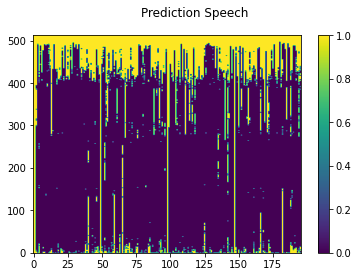

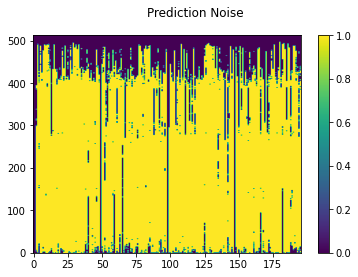

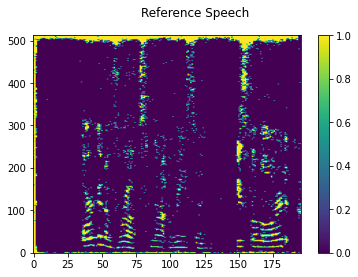

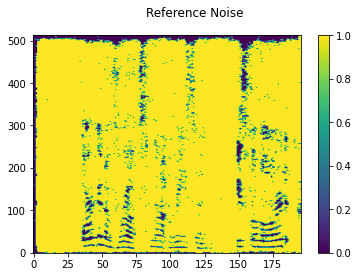

In [16]:
X = X.cpu()
Y = Y.cpu()
def evaluate_example(e_nr):
    model.eval()
    speech_pred = (model(X[e_nr])>0.2).float()
    noise_pred = torch.ones([513,X[e_nr].shape[1]])-speech_pred
    plot_mask(speech_pred, title="Prediction Speech")
    plot_mask(noise_pred, title="Prediction Noise")
    plot_mask(Y[e_nr][0], title="Reference Speech")
    plot_mask(Y[e_nr][1], title="Reference Noise")

def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

evaluate_example(100)

In [17]:
istft = torchaudio.transforms.InverseSpectrogram(n_fft=1024, hop_length=256)

def si_snr(estimate, reference, epsilon=1e-8):
        estimate = estimate - estimate.mean()
        reference = reference - reference.mean()
        reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
        mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
        scale = mix_pow / (reference_pow + epsilon)

        reference = scale * reference
        error = estimate - reference

        reference_pow = reference.pow(2)
        error_pow = error.pow(2)

        reference_pow = reference_pow.mean(axis=1)
        error_pow = error_pow.mean(axis=1)

        si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
        return si_snr.item()

def evaluateSiSNR(wave, i):
    score = si_snr(wave, speech[i])
    print(f"Si-SNR score: {score}") 
    return score

def maskToWave(speech_pred,noise_pred,mix,i):
        model.eval()
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix[i], speech_pred)
        psd_noise = psd_transform(mix[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix[i], psd_speech, psd_noise, reference_channel=0)
        waveform_souden = istft(stft_souden, length=len(speech[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

def save_sample(i,wave,sample_rate=SAMPLE_RATE):
    torchaudio.save("./outputs/output.wav",wave.reshape(1,-1),16000)
    torchaudio.save("./outputs/sample_reference.wav", speech[i].reshape(1,-1),sample_rate)
    torchaudio.save("./outputs/sample_input.wav", mix1[i].reshape(1,-1),sample_rate)

index = 201
speech_pred = (model(X[index])>0.2).float()
noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
wave = maskToWave(speech_pred,noise_pred,X_complex,index)#X hat nicht mehr nur 2, sondern 4 channel
print(wave.shape)
print(wave)
save_sample(index, wave=wave)
score = evaluateSiSNR(wave,index)#Should be ~28

torch.Size([50000])
tensor([-0.1016, -0.0597,  0.0421,  ...,  0.2004,  0.0385, -0.2737])
Si-SNR score: -31.590368270874023


In [18]:
scores = []
for index in range(2000,2050):
    print(index)
    speech_pred = (model(X[index])>0.2).float()
    noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
    wave = maskToWave(speech_pred,noise_pred,X_complex,index)#X hat nicht mehr nur 2, sondern 4 channel
    scores.append(si_snr(wave, speech[index])-si_snr(mix1[index],speech[index]))
print(f"Average Improvement of Si-SNR score on validation set: {np.mean(scores)}") # Average: 15

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
Average Improvement of Si-SNR score on validation set: -2.2172883796691893
